In [1]:
import ROOT
import uproot
import numpy as np
import pandas as pd
import torch 
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.22/00


In [2]:
sig_df = pd.read_pickle('DNN_ips/SUSY_Mstop_175_mchi_7_5.pkl')
tt_df  = pd.read_pickle('DNN_ips/ttbar.pkl')
vv_df  = pd.read_pickle('DNN_ips/VV.pkl')
st_df  = pd.read_pickle('DNN_ips/Single_top.pkl')
sat_df = pd.read_pickle('DNN_ips/Single_antitop.pkl')

In [3]:
Pol_rw  = np.loadtxt('txt_files/SUSY_weights_mstop_175_mchi_7_5_Pol_minus1.txt')
Ecom_rw = np.loadtxt('txt_files/SUSY_Ecom_rw.txt')
Rw      = Pol_rw * Ecom_rw

In [4]:
# Standardize

sig_mean = sig_df.mean()
sig_std  = sig_df.std()

tt_mean = tt_df.mean()
tt_std  = tt_df.std()

st_mean = st_df.mean()
st_std  = st_df.std()

vv_mean = vv_df.mean()
vv_std  = vv_df.std()

sat_mean = sat_df.mean()
sat_std  = sat_df.std()

sig_df = (sig_df - sig_mean)/ sig_std
tt_df  = (tt_df  - tt_mean)/ tt_std
st_df  = (st_df  - st_mean)/ st_std
vv_df  = (vv_df  - vv_mean)/ vv_std
sat_df = (sat_df  - sat_mean)/ sat_std

In [5]:
# Set both to equal sizes 
# Reducing the bkg dataframe size

sig_df_train = sig_df[1:50000]
tt_df_train  = tt_df[1:40000]
st_df_train  = st_df[1:10000]
sat_df_train = sat_df[1:10000]
vv_df_train  = vv_df[1:1000]

In [6]:
bkgList = [tt_df_train, st_df_train, sat_df_train, vv_df_train]  # List of your dataframes

bkg_df_train = pd.concat(bkgList)

signal = sig_df_train.values
bkg    = bkg_df_train.values

sig_label = np.ones(len(signal))
bkg_label = np.zeros(len(bkg))

data      = np.concatenate((signal,bkg))
label     = np.concatenate((sig_label,bkg_label))

In [7]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=2, shuffle=True)
skf.get_n_splits(data, label)
skf.split(data, label)

<generator object _BaseKFold.split at 0x7fbf7d88ad60>

In [8]:
for train_index, test_index in skf.split(data, label):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = label[train_index], label[test_index]

TRAIN: [     0      3      4 ... 110989 110990 110993] TEST: [     1      2      5 ... 110991 110992 110994]
TRAIN: [     1      2      5 ... 110991 110992 110994] TEST: [     0      3      4 ... 110989 110990 110993]


In [10]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

In [11]:
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from skopt import gp_minimize

model = Sequential()
model.add(Dense(100, input_dim = 19  ,activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(100, input_dim = 100 ,activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               2000      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 12,201
Trainable params: 12,201
Non-trainable params: 0
_________________________________________________________________


2021-02-04 20:52:30.226413: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-02-04 20:52:30.286341: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbf82839540 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-02-04 20:52:30.286359: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [12]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [13]:
hist = model.fit(x_train, y_train, batch_size=50, epochs=1000,verbose=1, shuffle=True, validation_split=0.2,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min'),
                  ModelCheckpoint(filepath='model.h5', verbose=0)])

Epoch 1/1000
888/888 [==============================] - 2s 2ms/step - loss: 0.7016 - accuracy: 0.5234 - val_loss: 0.6916 - val_accuracy: 0.5366
Epoch 2/1000
888/888 [==============================] - 2s 2ms/step - loss: 0.6931 - accuracy: 0.5345 - val_loss: 0.6899 - val_accuracy: 0.5400
Epoch 3/1000
888/888 [==============================] - 2s 2ms/step - loss: 0.6905 - accuracy: 0.5396 - val_loss: 0.6894 - val_accuracy: 0.5467
Epoch 4/1000
888/888 [==============================] - 2s 2ms/step - loss: 0.6889 - accuracy: 0.5458 - val_loss: 0.6890 - val_accuracy: 0.5470
Epoch 5/1000
888/888 [==============================] - 2s 2ms/step - loss: 0.6884 - accuracy: 0.5479 - val_loss: 0.6891 - val_accuracy: 0.5440
Epoch 6/1000
888/888 [==============================] - 1s 2ms/step - loss: 0.6882 - accuracy: 0.5475 - val_loss: 0.6883 - val_accuracy: 0.5463
Epoch 7/1000
888/888 [==============================] - 2s 2ms/step - loss: 0.6880 - accuracy: 0.5473 - val_loss: 0.6881 - val_accuracy:

888/888 [==============================] - 1s 2ms/step - loss: 0.2033 - accuracy: 0.9165 - val_loss: 0.1823 - val_accuracy: 0.9247: 0s - los
Epoch 58/1000
888/888 [==============================] - 2s 2ms/step - loss: 0.2041 - accuracy: 0.9151 - val_loss: 0.1871 - val_accuracy: 0.9235
Epoch 59/1000
888/888 [==============================] - 2s 2ms/step - loss: 0.2032 - accuracy: 0.9165 - val_loss: 0.1508 - val_accuracy: 0.9435
Epoch 60/1000
888/888 [==============================] - 2s 2ms/step - loss: 0.2015 - accuracy: 0.9169 - val_loss: 0.1588 - val_accuracy: 0.9352
Epoch 61/1000
888/888 [==============================] - 1s 2ms/step - loss: 0.1986 - accuracy: 0.9194 - val_loss: 0.1755 - val_accuracy: 0.9343
Epoch 62/1000
888/888 [==============================] - 2s 2ms/step - loss: 0.2001 - accuracy: 0.9196 - val_loss: 0.1720 - val_accuracy: 0.9283
Epoch 63/1000
888/888 [==============================] - 2s 2ms/step - loss: 0.1996 - accuracy: 0.9189 - val_loss: 0.1579 - val_accura

888/888 [==============================] - 2s 2ms/step - loss: 0.1761 - accuracy: 0.9265 - val_loss: 0.1378 - val_accuracy: 0.9443
Epoch 114/1000
888/888 [==============================] - 2s 2ms/step - loss: 0.1745 - accuracy: 0.9275 - val_loss: 0.1440 - val_accuracy: 0.9370
Epoch 115/1000
888/888 [==============================] - 1s 2ms/step - loss: 0.1713 - accuracy: 0.9295 - val_loss: 0.1494 - val_accuracy: 0.9355
Epoch 116/1000
888/888 [==============================] - 2s 2ms/step - loss: 0.1712 - accuracy: 0.9300 - val_loss: 0.1493 - val_accuracy: 0.9365
Epoch 117/1000
888/888 [==============================] - 1s 2ms/step - loss: 0.1745 - accuracy: 0.9286 - val_loss: 0.1443 - val_accuracy: 0.9393
Epoch 118/1000
888/888 [==============================] - 1s 2ms/step - loss: 0.1733 - accuracy: 0.9278 - val_loss: 0.1378 - val_accuracy: 0.9418
Epoch 119/1000
888/888 [==============================] - 2s 2ms/step - loss: 0.1741 - accuracy: 0.9268 - val_loss: 0.1485 - val_accuracy: 

888/888 [==============================] - 2s 3ms/step - loss: 0.1354 - accuracy: 0.9465 - val_loss: 0.0969 - val_accuracy: 0.9575
Epoch 170/1000
888/888 [==============================] - 2s 2ms/step - loss: 0.1369 - accuracy: 0.9468 - val_loss: 0.0853 - val_accuracy: 0.9641
Epoch 171/1000
888/888 [==============================] - 5s 6ms/step - loss: 0.1352 - accuracy: 0.9474 - val_loss: 0.0795 - val_accuracy: 0.9684
Epoch 172/1000
888/888 [==============================] - 3s 4ms/step - loss: 0.1304 - accuracy: 0.9487 - val_loss: 0.0823 - val_accuracy: 0.9668
Epoch 173/1000
888/888 [==============================] - 4s 4ms/step - loss: 0.1321 - accuracy: 0.9486 - val_loss: 0.0935 - val_accuracy: 0.9605
Epoch 174/1000
888/888 [==============================] - 2s 3ms/step - loss: 0.1357 - accuracy: 0.9468 - val_loss: 0.1045 - val_accuracy: 0.9544
Epoch 175/1000
888/888 [==============================] - 2s 3ms/step - loss: 0.1321 - accuracy: 0.9472 - val_loss: 0.0861 - val_accuracy: 

Epoch 225/1000
888/888 [==============================] - 3s 4ms/step - loss: 0.1209 - accuracy: 0.9523 - val_loss: 0.0719 - val_accuracy: 0.9719
Epoch 226/1000
888/888 [==============================] - 4s 4ms/step - loss: 0.1269 - accuracy: 0.9506 - val_loss: 0.0955 - val_accuracy: 0.9592
Epoch 227/1000
888/888 [==============================] - 2s 2ms/step - loss: 0.1167 - accuracy: 0.9531 - val_loss: 0.0826 - val_accuracy: 0.9673
Epoch 228/1000
888/888 [==============================] - 2s 2ms/step - loss: 0.1263 - accuracy: 0.9507 - val_loss: 0.0993 - val_accuracy: 0.9598
Epoch 229/1000
888/888 [==============================] - 2s 2ms/step - loss: 0.1192 - accuracy: 0.9540 - val_loss: 0.0854 - val_accuracy: 0.9644
Epoch 230/1000
888/888 [==============================] - 2s 2ms/step - loss: 0.1195 - accuracy: 0.9524 - val_loss: 0.0860 - val_accuracy: 0.9644
Epoch 231/1000
888/888 [==============================] - 1s 2ms/step - loss: 0.1257 - accuracy: 0.9514 - val_loss: 0.0807 -

Epoch 281/1000
888/888 [==============================] - 2s 2ms/step - loss: 0.1147 - accuracy: 0.9551 - val_loss: 0.0790 - val_accuracy: 0.9695
Epoch 282/1000
888/888 [==============================] - 2s 2ms/step - loss: 0.1213 - accuracy: 0.9532 - val_loss: 0.0634 - val_accuracy: 0.9772
Epoch 283/1000
888/888 [==============================] - 2s 2ms/step - loss: 0.1155 - accuracy: 0.9549 - val_loss: 0.0748 - val_accuracy: 0.9718
Epoch 284/1000
888/888 [==============================] - 2s 2ms/step - loss: 0.1092 - accuracy: 0.9574 - val_loss: 0.1246 - val_accuracy: 0.9509
Epoch 285/1000
888/888 [==============================] - 1s 2ms/step - loss: 0.1191 - accuracy: 0.9532 - val_loss: 0.0687 - val_accuracy: 0.9722
Epoch 286/1000
888/888 [==============================] - 2s 3ms/step - loss: 0.1121 - accuracy: 0.9554 - val_loss: 0.0712 - val_accuracy: 0.9727
Epoch 287/1000
888/888 [==============================] - 2s 2ms/step - loss: 0.1198 - accuracy: 0.9532 - val_loss: 0.0768 -

888/888 [==============================] - 1s 1ms/step - loss: 0.1026 - accuracy: 0.9600 - val_loss: 0.0672 - val_accuracy: 0.9732
Epoch 338/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1042 - accuracy: 0.9602 - val_loss: 0.0783 - val_accuracy: 0.9704
Epoch 339/1000
888/888 [==============================] - 1s 2ms/step - loss: 0.1066 - accuracy: 0.9602 - val_loss: 0.0713 - val_accuracy: 0.9737
Epoch 340/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1074 - accuracy: 0.9588 - val_loss: 0.0848 - val_accuracy: 0.9651
Epoch 341/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1053 - accuracy: 0.9595 - val_loss: 0.0662 - val_accuracy: 0.9749
Epoch 342/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1049 - accuracy: 0.9604 - val_loss: 0.0753 - val_accuracy: 0.9711
Epoch 343/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1092 - accuracy: 0.9591 - val_loss: 0.0711 - val_accuracy: 

In [75]:
# serialize model to JSON
model_json = model.to_json()
with open("Mstop_175_mchi_7_5.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("Mstop_175_mchi_7_5.h5")
print("Saved model to disk")

Saved model to disk


In [10]:
# load json and create model
json_file = open('Mstop_175_mchi_7_5.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("Mstop_175_mchi_7_5.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

NameError: name 'model_from_json' is not defined

In [16]:
def show_losses( histories ):
    plt.figure(figsize=(10,10))
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel('Loss' , fontsize=15)
    plt.tick_params(axis="y", labelsize=15)
    plt.tick_params(axis="x", labelsize=15)
    plt.title('Training Error by Epoch', fontsize=15)
    colors=[]
    do_acc=False
    for label,loss in histories:
        color = tuple(np.random.random(3))
        colors.append(color)
        l = label
        vl= label+" validation"
        if 'acc' in loss.history:
            l+=' (acc %2.4f)'% (loss.history['acc'][-1])
            do_acc = True
        if 'val_acc' in loss.history:
            vl+=' (val acc %2.4f)'% (loss.history['val_acc'][-1])
            do_acc = True
        plt.plot(loss.history['loss'], label=l, color=color)
        if 'val_loss' in loss.history:
            plt.plot(loss.history['val_loss'], lw=2, ls='dashed', label=vl, color=color)

    plt.legend(fontsize=15)
    #plt.yscale('log')
    plt.show()
    if not do_acc: return
    plt.figure(figsize=(10,10))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    for i,(label,loss) in enumerate(histories):
        color = colors[i]
        if 'acc' in loss.history:
            plt.plot(loss.history['acc'], lw=2, label=label+" accuracy", color=color)
        if 'val_acc' in loss.history:
            plt.plot(loss.history['val_acc'], lw=2, ls='dashed', label=label+" validation accuracy", color=color)

    plt.show()

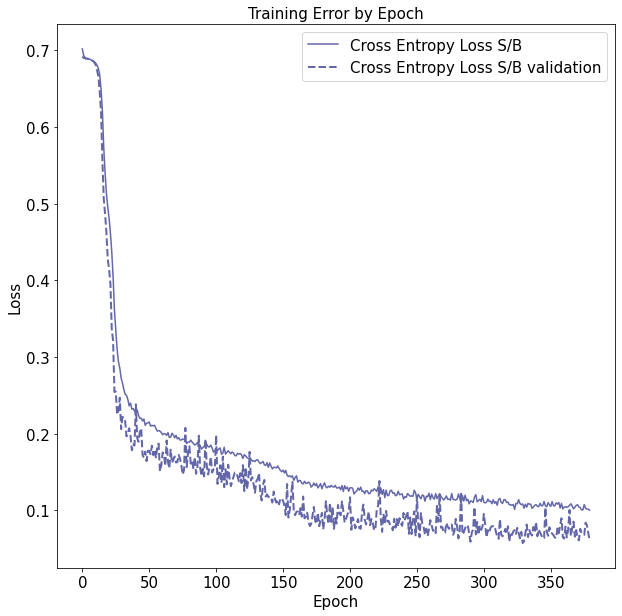

In [17]:
show_losses( [("Cross Entropy Loss S/B", hist)])

In [18]:
from sklearn.metrics import roc_curve
y_pred_train = model.predict(x_train).ravel()
y_pred_test  = model.predict(x_test).ravel()

fpr_keras_train, tpr_keras_train, thresholds_keras = roc_curve(y_train, y_pred_train)
fpr_keras_test , tpr_keras_test , thresholds_keras = roc_curve(y_test , y_pred_test)

In [19]:
from sklearn.metrics import auc
auc_keras_test  = auc(fpr_keras_test, tpr_keras_test)
auc_keras_train = auc(fpr_keras_train, tpr_keras_train)

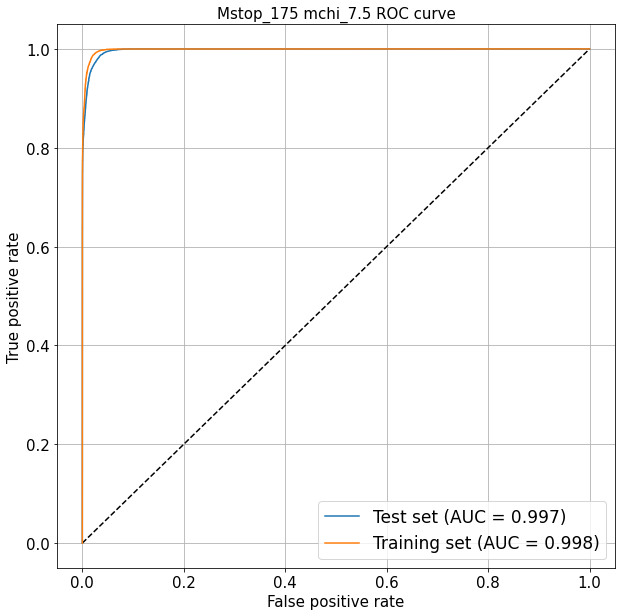

In [20]:
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_test , tpr_keras_test , label='Test set (AUC = {:.3f})'.format(auc_keras_test))
plt.plot(fpr_keras_train, tpr_keras_train, label='Training set (AUC = {:.3f})'.format(auc_keras_train))
plt.tick_params(axis="y", labelsize=15)
plt.tick_params(axis="x", labelsize=15)
plt.xlabel('False positive rate', fontsize=15)
plt.ylabel('True positive rate' , fontsize=15)
plt.title('Mstop_175 mchi_7.5 ROC curve', fontsize=15)
plt.legend(loc='lower right', fontsize=17)
plt.grid()
plt.show()

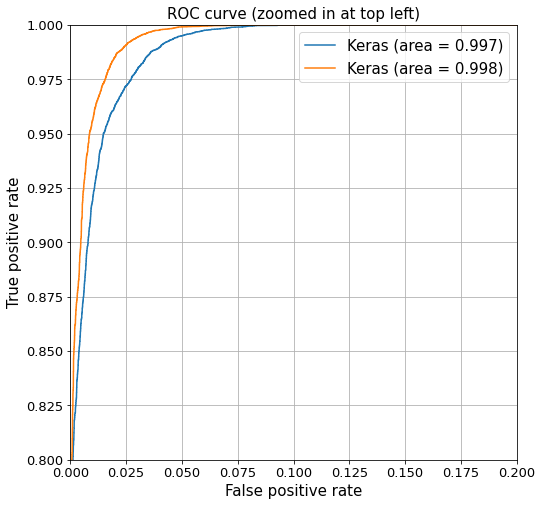

In [25]:
# Zoom in view of the upper left corner.
plt.figure(figsize=(8,8))
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_test , tpr_keras_test , label='Keras (area = {:.3f})'.format(auc_keras_test))
plt.plot(fpr_keras_train, tpr_keras_train, label='Keras (area = {:.3f})'.format(auc_keras_train))
plt.ylabel('True positive rate' , fontsize=15)
plt.xlabel('False positive rate', fontsize=15)
plt.tick_params(axis="y", labelsize=13)
plt.tick_params(axis="x", labelsize=13)
plt.title('ROC curve (zoomed in at top left)', fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.grid()
plt.show()

In [26]:
tt_pred  = model.predict(tt_df[40000:]) 
st_pred  = model.predict(st_df[10000:]) 
sat_pred = model.predict(sat_df[10000:]) 
vv_pred  = model.predict(vv_df[1000:]) 
si_pred  = model.predict(sig_df[50000:])

In [27]:
st_list = [st_pred, sat_pred]
st_arr  = np.array(st_list)

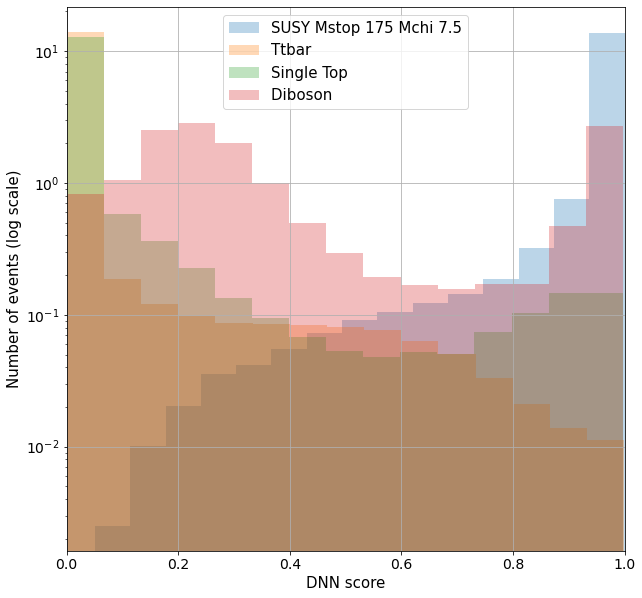

In [31]:
plt.figure(figsize=(10,10))
plt.tick_params(axis="y", labelsize=14)
plt.tick_params(axis="x", labelsize=14)
plt.hist(si_pred, bins=15, alpha=0.3, label='SUSY Mstop 175 Mchi 7.5', density=True)
plt.hist(tt_pred, bins=15, alpha=0.3, label='Ttbar', density=True)
plt.hist(st_pred, bins=15, alpha=0.3, label='Single Top', density=True)
plt.hist(vv_pred, bins=15, alpha=0.3, label='Diboson ', density=True)
#plt.hist(sat_pred, bins=15, alpha=0.3, label='Single Antitop')
plt.yscale('log')
plt.xlim(0,1)
plt.xlabel('DNN score', fontsize=15)
plt.ylabel('Number of events (log scale)', fontsize=15)
plt.grid()
plt.legend(loc='best', fontsize=15)

In [18]:
np.savetxt('Mstop_175_mchi_7_5_SUSY_pred.txt', si_pred)
np.savetxt('Mstop_175_mchi_7_5_tt_pred.txt'  , tt_pred)
np.savetxt('Mstop_175_mchi_7_5_st_pred.txt'  , st_pred)
np.savetxt('Mstop_175_mchi_7_5_sat_pred.txt' , sat_pred)
np.savetxt('Mstop_175_mchi_7_5_vv_pred.txt'  , vv_pred)

In [22]:
SUSY_lep_pt_arr = sig_df['lepton_pt']
tt_lep_pt_arr   = tt_df['lepton_pt']
st_lep_pt_arr   = st_df['lepton_pt']

<ipython-input-21-39e9427f7984>:20: RuntimeWarning: invalid value encountered in true_divide
  ns1 / ns2,      # maybe check for div-by-zero!


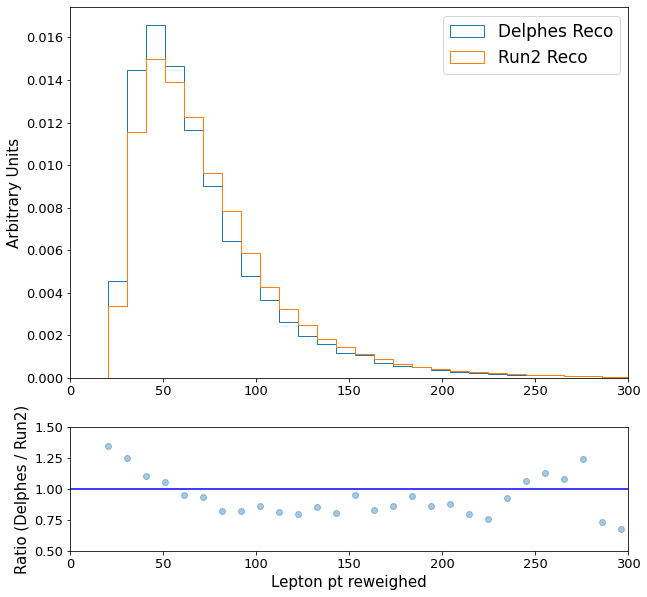

In [21]:
bins = np.linspace(0,500, 50)

fig_style = {
    'figsize': (10, 10),
}

ratio_fig_style = {
    'figsize': (10, 10),
    'gridspec_kw': {'height_ratios': (3, 1)},
}


fig, (ax1, ax2) = plt.subplots(nrows=2, **ratio_fig_style)
ns1, bins1, patches  = ax1.hist(np.clip(SUSY_lep_pt_arr, bins[0], bins[-1]), density=True, histtype='step', bins=bins, label='Delphes Reco', weights=Pol_rw)
ns2, bins2, patches  = ax1.hist(np.clip(tt_lep_pt_arr  , bins[0], bins[-1]), density=True, histtype='step', bins=bins, label='Run2 Reco')

ax1.legend(prop={'size': 17}, loc='upper right')
ax1.set_xlim(0, 300)
ax2.scatter(bins[:-1],  # this is what makes it comparable
        ns1 / ns2,      # maybe check for div-by-zero!
        alpha=0.4)

ax1.set_ylabel('Arbitrary Units', fontsize=15)
ax2.set_ylabel('Ratio (Delphes / Run2)', fontsize=15)
ax2.set_xlabel('Lepton pt reweighed', fontsize=15)
ax2.set_ylim(0.5,1.5)
ax2.set_xlim(0,300)

ax1.tick_params(axis="x", labelsize=13)
ax2.tick_params(axis="x", labelsize=13)

ax1.tick_params(axis="y", labelsize=13)
ax2.tick_params(axis="y", labelsize=13)
plt.axhline(y=1, color='b', linestyle='-')
plt.show()

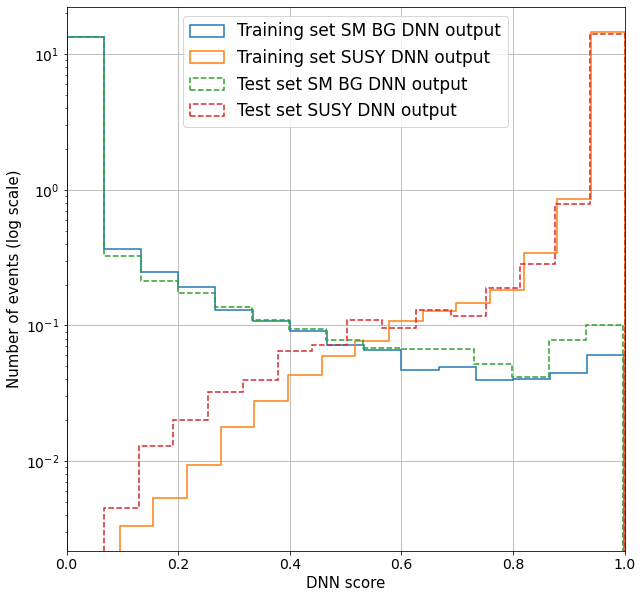

In [30]:
plt.figure(figsize=(10,10))
plt.tick_params(axis="y", labelsize=14)
plt.tick_params(axis="x", labelsize=14)
plt.hist(y_pred_train[y_train == 0], bins=15, label='Training set SM BG DNN output', histtype='step', linestyle='solid', linewidth=1.5, density=True)
plt.hist(y_pred_train[y_train == 1], bins=15, label='Training set SUSY DNN output', histtype='step' , linestyle='solid', linewidth=1.5, density=True)
plt.hist(y_pred_test[y_test == 0], bins=15, label='Test set SM BG DNN output', histtype='step' , linestyle='dashed', linewidth=1.5, density=True)
plt.hist(y_pred_test[y_test == 1], bins=15, label='Test set SUSY DNN output ', histtype='step' , linestyle='dashed', linewidth=1.5, density=True)

plt.yscale('log')
plt.xlim(0,1)
plt.xlabel('DNN score', fontsize=15)
plt.ylabel('Number of events (log scale)', fontsize=15)
plt.grid()
plt.legend(loc='upper center', fontsize=17)